In [1]:
import pandas as pd

In [ ]:
# first non-null value per column per dataset

# AUSER
# Rainfall_Gallicano ... 01/01/06 -- 06/30/20
# Rainfall_Pontetetto ... 01/01/06 -- 06/30/20
# Rainfall_Monte_Serra ... 01/01/06 -- 06/30/20
# Rainfall_Orentano ... 01/01/06 -- 06/30/20
# Rainfall_Borgo_a_Mozzano ... 01/01/06 -- 06/30/20
# Rainfall_Piaggione ... 01/01/06 -- 06/30/20
# Rainfall_Calavorno ... 01/01/06 -- 06/30/20
# Rainfall_Croce_Arcana ... 01/01/06 -- 06/30/20
# Rainfall_Tereglio_Coreglia_Antelminelli ... 01/01/06 -- 06/30/20
# Rainfall_Fabbriche_di_Vallico ... 01/01/06 -- 06/30/20
# * Depth_to_Groundwater_LT2 ... 01/01/06 -- 06/30/20
# * Depth_to_Groundwater_SAL ... 04/06/07 -- 06/30/20
# Depth_to_Groundwater_PAG ... 01/01/09 -- 06/30/20
# * Depth_to_Groundwater_CoS ... 06/29/06 -- 06/30/20
# Depth_to_Groundwater_DIEC ... 01/02/11 -- 06/30/20
# Temperature_Orentano ... 03/05/98 -- 06/30/20
# Temperature_Monte_Serra ... 03/05/98 -- 06/30/20
# Temperature_Ponte_a_Moriano ... 03/05/98 -- 06/30/20
# Temperature_Lucca_Orto_Botanico ... 03/05/98 -- 06/30/20
# Volume_POL ... 01/01/05 -- 06/30/20
# Volume_CC1 ... 01/01/05 -- 06/30/20
# Volume_CC2 ... 01/01/05 -- 06/30/20
# Volume_CSA ... 01/01/05 -- 06/30/20
# Volume_CSAL ... 01/01/05 -- 06/30/20
# Hydrometry_Monte_S_Quirico ... 01/01/00 -- 06/30/20
# Hydrometry_Piaggione ... 01/01/00 -- 06/30/20

# DOGANELLA
# Rainfall_Monteporzio ... 01/01/04 -- 06/30/20
# Rainfall_Velletri ... 01/01/04 -- 06/30/20
# * Depth_to_Groundwater_Pozzo_1 ... 06/01/12 -- 06/30/20
# * Depth_to_Groundwater_Pozzo_2 ... 06/01/12 -- 06/30/20
# * Depth_to_Groundwater_Pozzo_3 ... 06/01/12 -- 06/30/20
# * Depth_to_Groundwater_Pozzo_4 ... 06/01/12 -- 06/30/20
# * Depth_to_Groundwater_Pozzo_5 ... 06/01/12 -- 06/30/20
# * Depth_to_Groundwater_Pozzo_6 ... 06/01/12 -- 06/30/20
# * Depth_to_Groundwater_Pozzo_7 ... 06/01/12 -- 06/30/20
# * Depth_to_Groundwater_Pozzo_8 ... 06/01/12 -- 06/30/20
# * Depth_to_Groundwater_Pozzo_9 ... 06/01/12 -- 06/30/20
# Volume_Pozzo_1 ... 10/07/16 -- 06/30/20
# Volume_Pozzo_2 ... 10/07/16 -- 06/30/20
# Volume_Pozzo_3 ... 10/07/16 -- 06/30/20
# Volume_Pozzo_4 ... 10/07/16 -- 06/30/20
# Volume_Pozzo_5+6 ... 10/07/16 -- 06/30/20
# Volume_Pozzo_7 ... 10/07/16 -- 06/30/20
# Volume_Pozzo_8 ... 10/07/16 -- 06/30/20
# Volume_Pozzo_9 ... 10/07/16 -- 06/30/20
# Temperature_Monteporzio ... 01/01/04 -- 06/30/20
# Temperature_Velletri ... 01/01/04 -- 06/30/20

# LUCO
# Rainfall_Simignano ... 02/24/00 -- 06/30/20
# Rainfall_Siena_Poggio_al_Vento ... 11/23/17 -- 06/30/20
# Rainfall_Mensano ... 10/14/15 -- 06/30/20
# Rainfall_Montalcinello ... 04/04/02 -- 06/30/20
# Rainfall_Monticiano_la_Pineta ... 06/18/14 -- 06/30/20
# Rainfall_Sovicille ... 04/04/02 -- 06/30/20
# Rainfall_Ponte_Orgia ... 01/18/17 -- 06/30/20
# Rainfall_Scorgiano ... 01/01/12 -- 06/30/20
# Rainfall_Pentolina ... 01/01/12 -- 06/30/20
# Rainfall_Monteroni_Arbia_Biena ... 01/01/12 -- 06/30/20
# * Depth_to_Groundwater_Podere_Casetta ... 02/21/08 -- 01/12/19
# Depth_to_Groundwater_Pozzo_1 ... 09/01/17 -- 06/30/20
# Depth_to_Groundwater_Pozzo_3 ... 09/01/17 -- 06/30/20
# Depth_to_Groundwater_Pozzo_4 ... 09/01/17 -- 06/30/20
# Temperature_Siena_Poggio_al_Vento ... 01/01/00 -- 06/30/20
# Temperature_Mensano ... 01/01/00 -- 06/30/20
# Temperature_Pentolina ... 01/01/00 -- 06/30/20
# Temperature_Monteroni_Arbia_Biena ... 01/01/00 -- 06/30/20
# Volume_Pozzo_1 ... 01/01/15 -- 06/30/20
# Volume_Pozzo_3 ... 01/01/15 -- 06/30/20
# Volume_Pozzo_4 ... 01/01/15 -- 06/30/20

# PETRIGNANO
# Rainfall_Bastia_Umbra ... 01/01/09 -- 06/30/20
# * Depth_to_Groundwater_P24 ... 03/14/06 -- 06/30/20
# * Depth_to_Groundwater_P25 ... 03/14/06 -- 06/30/20
# Temperature_Bastia_Umbra ... 01/01/09 -- 06/30/20
# Temperature_Petrignano ... 01/01/09 -- 06/30/20
# Volume_C10_Petrignano ... 09/27/06 -- 06/30/20
# Hydrometry_Fiume_Chiascio_Petrignano ... 01/01/09 -- 06/30/20

In [290]:
from sklearn.preprocessing import StandardScaler

def load_data(path, X, y):
    df = pd.read_csv(path)
    
    # set date as the index
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df = df.set_index('Date', drop=True)
    df.index.name = None
    df.index.freq = 'D'
    
    # find the latest date of first non-null
    # amongst our targets; throw away all data
    # prior to this point in time
    sent = None
    for c in y:
        data = df[~df[c].isnull()]
        if data.shape[0] > 0:
            d = data.iloc[0].name
            if sent is None or d > sent:
                sent = d
    if sent is not None:
        df = df.loc[sent:]

    # similarly, find the earliest date of last non-null
    # among the targets, again for trimming purposes
    sent = None
    for c in y:
        data = df[~df[c].isnull()]
        if data.shape[0] > 0:
            d = data.iloc[-1].name
            if sent is None or d < sent:
                sent = d
    if sent is not None:
        df = df.loc[:sent]
        
    # 0 in the target always represents a missing value
    for c in y:
        df[c] = df[c].replace(0, float('nan'))

    # discard features with >70% nulls
    xnulls = df[X].isnull().sum() / df.shape[0]
    Xs = df[xnulls[xnulls < 0.7].index]
    X = Xs.columns
    df = Xs.join(df[y])
    
    # take the absolute value of some columns
    abs_starts = [
        'Rainfall',
        'Depth_to_Groundwater',
        'Volume'
    ]
    for beg in abs_starts:
        cols = [c for c in df.columns if c.startswith(beg)]
        for c in cols:
            df[c] = df[c].abs()

    # multiple imputation
    kernel = mf.MultipleImputedKernel(
        data=df,
        save_all_iterations=False,
        random_state=143
    )
    kernel.mice(3, verbose=False)
    df = kernel.impute_new_data(df).complete_data(0)
    
    # center & scale
    scal = StandardScaler()
    df = pd.DataFrame(
        scal.fit_transform(df),
        columns=df.columns,
        index=df.index
    )
    
    return df[X], df[y]

In [194]:
def load_auser():
    return load_data(
        '../data/raw/aquifer/auser.csv',
        [
            'Rainfall_Gallicano',
            'Rainfall_Pontetetto',
            'Rainfall_Monte_Serra',
            'Rainfall_Orentano',
            'Rainfall_Borgo_a_Mozzano',
            'Rainfall_Piaggione',
            'Rainfall_Calavorno',
            'Rainfall_Croce_Arcana',
            'Rainfall_Tereglio_Coreglia_Antelminelli',
            'Rainfall_Fabbriche_di_Vallico',
            'Depth_to_Groundwater_PAG',
            'Depth_to_Groundwater_DIEC',
            'Temperature_Orentano',
            'Temperature_Monte_Serra',
            'Temperature_Ponte_a_Moriano',
            'Temperature_Lucca_Orto_Botanico',
            'Volume_POL',
            'Volume_CC1',
            'Volume_CC2',
            'Volume_CSA',
            'Volume_CSAL',
            'Hydrometry_Monte_S_Quirico',
            'Hydrometry_Piaggione'
        ],
        [
            'Depth_to_Groundwater_SAL',
            'Depth_to_Groundwater_CoS',
            'Depth_to_Groundwater_LT2'
        ]
    )

def load_doganella():
    return load_data(
        '../data/raw/aquifer/doganella.csv',
        [
            'Rainfall_Monteporzio',
            'Rainfall_Velletri',
            'Volume_Pozzo_1',
            'Volume_Pozzo_2',
            'Volume_Pozzo_3',
            'Volume_Pozzo_4',
            'Volume_Pozzo_5+6',
            'Volume_Pozzo_7',
            'Volume_Pozzo_8',
            'Volume_Pozzo_9',
            'Temperature_Monteporzio',
            'Temperature_Velletri'
        ],
        [
            'Depth_to_Groundwater_Pozzo_1',
            'Depth_to_Groundwater_Pozzo_2',
            'Depth_to_Groundwater_Pozzo_3',
            'Depth_to_Groundwater_Pozzo_4',
            'Depth_to_Groundwater_Pozzo_5',
            'Depth_to_Groundwater_Pozzo_6',
            'Depth_to_Groundwater_Pozzo_7',
            'Depth_to_Groundwater_Pozzo_8',
            'Depth_to_Groundwater_Pozzo_9'
        ]
    )

def load_luco():
    return load_data(
        '../data/raw/aquifer/luco.csv',
        [
            'Rainfall_Simignano',
            'Rainfall_Siena_Poggio_al_Vento',
            'Rainfall_Mensano',
            'Rainfall_Montalcinello',
            'Rainfall_Monticiano_la_Pineta',
            'Rainfall_Sovicille',
            'Rainfall_Ponte_Orgia',
            'Rainfall_Scorgiano',
            'Rainfall_Pentolina',
            'Rainfall_Monteroni_Arbia_Biena',
            'Depth_to_Groundwater_Pozzo_1',
            'Depth_to_Groundwater_Pozzo_3',
            'Depth_to_Groundwater_Pozzo_4',
            'Temperature_Siena_Poggio_al_Vento',
            'Temperature_Mensano',
            'Temperature_Pentolina',
            'Temperature_Monteroni_Arbia_Biena',
            'Volume_Pozzo_1',
            'Volume_Pozzo_3',
            'Volume_Pozzo_4'
        ],
        [
            'Depth_to_Groundwater_Podere_Casetta'
        ]
    )

def load_petrignano():
    return load_data(
        '../data/raw/aquifer/petrignano.csv',
        [
            'Rainfall_Bastia_Umbra',
            'Temperature_Bastia_Umbra',
            'Temperature_Petrignano',
            'Volume_C10_Petrignano',
            'Hydrometry_Fiume_Chiascio_Petrignano'
        ],
        [
            'Depth_to_Groundwater_P24',
            'Depth_to_Groundwater_P25'
        ]
    )

In [291]:
auserX, auserY = load_auser()
doganellaX, doganellaY = load_doganella()
lucoX, lucoY = load_luco()
petrignanoX, petrignanoY = load_petrignano()

In [292]:
import numpy as np
import matplotlib.pyplot as plt
import miceforest as mf
from sklearn.preprocessing import StandardScaler

class ForecastWrapper:
    
    def fit(self, X, y):
        self._outshape = 1 if len(y.shape) == 1 else y.shape[1]
        self._onedim = self._outshape == 1
        return self
    
    def predict(self, n):
        return np.zeros((n, self._outshape))

In [254]:
from sklearn.model_selection import TimeSeriesSplit
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [293]:
import warnings
warnings.filterwarnings('ignore')

tests = (
    ('Auser', auserX, auserY),
    ('Doganella', doganellaX, doganellaY),
    ('Luco', lucoX, lucoY),
    ('Petrignano', petrignanoX, petrignanoY)
)

scores = dict()
preds = dict()

for aid, X, y in tests:
    scores[aid] = dict()
    preds[aid] = dict()
    for c in y.columns:
        scores[aid][c] = dict(
            rmse=[],
            mae=[]
        )
        preds[aid][c] = []
    k = math.floor(len(X) / 7)
    tscv = TimeSeriesSplit(k)
    for tr, tt in tscv.split(X, y):
        fw = ForecastWrapper()
        X_train, X_test = X.iloc[tr], X.iloc[tt]
        y_train, y_test = y.iloc[tr], y.iloc[tt]
        fw.fit(X_train, y_train)
        y_pred = pd.DataFrame(
            fw.predict(len(y_test)),
            columns=y_test.columns,
            index=y_test.index
        )
        rmse = mean_squared_error(y_test, y_pred, squared=False, multioutput='raw_values')
        mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
        for i, c in enumerate(y.columns):
            preds[aid][c].append(y_pred[c])
            scores[aid][c]['rmse'].append(rmse[i])
            scores[aid][c]['mae'].append(mae[i])

mean_scores = {
    k: {
        c: {
            m: np.mean(vs) for m, vs in mets.items()
        } for c, mets in y.items()
    } for k, y in scores.items()
}

mean_scores = {k:pd.DataFrame(v).T for k,v in mean_scores.items()}

In [256]:
cleans['Auser'][-1][1].head()

,Depth_to_Groundwater_SAL,Depth_to_Groundwater_CoS,Depth_to_Groundwater_LT2
2007-04-06,1.774801,-1.220210,1.683460
2007-04-07,1.809559,-1.242490,1.694571
2007-04-08,1.740042,-1.242490,1.694571
2007-04-09,1.653145,-1.287050,1.705681
2007-04-10,1.687904,-1.301904,1.716792


In [296]:
import matplotlib.pyplot as plt

def plot_target_predictions(tag, full, targets):
    fig, axs = plt.subplots(len(targets), 1, figsize=(20,5*len(targets)))
    fig.suptitle(f"{tag} Target Predictions")
    if len(targets) == 1:
        axs = [axs]
    for i, c in enumerate(targets):
        axs[i].scatter(full.index, full[c], s=1, alpha=0.75)
        s1 = mean_scores[tag].loc[c]['rmse']
        s2 = mean_scores[tag].loc[c]['mae']
        axs[i].set_title(f"{c} | RMSE {s1} ... MAE {s2}")
        for p in preds[tag][c]:
            axs[i].scatter(p.index, p.values, s=1, c='C3', alpha=0.25)
    plt.show()

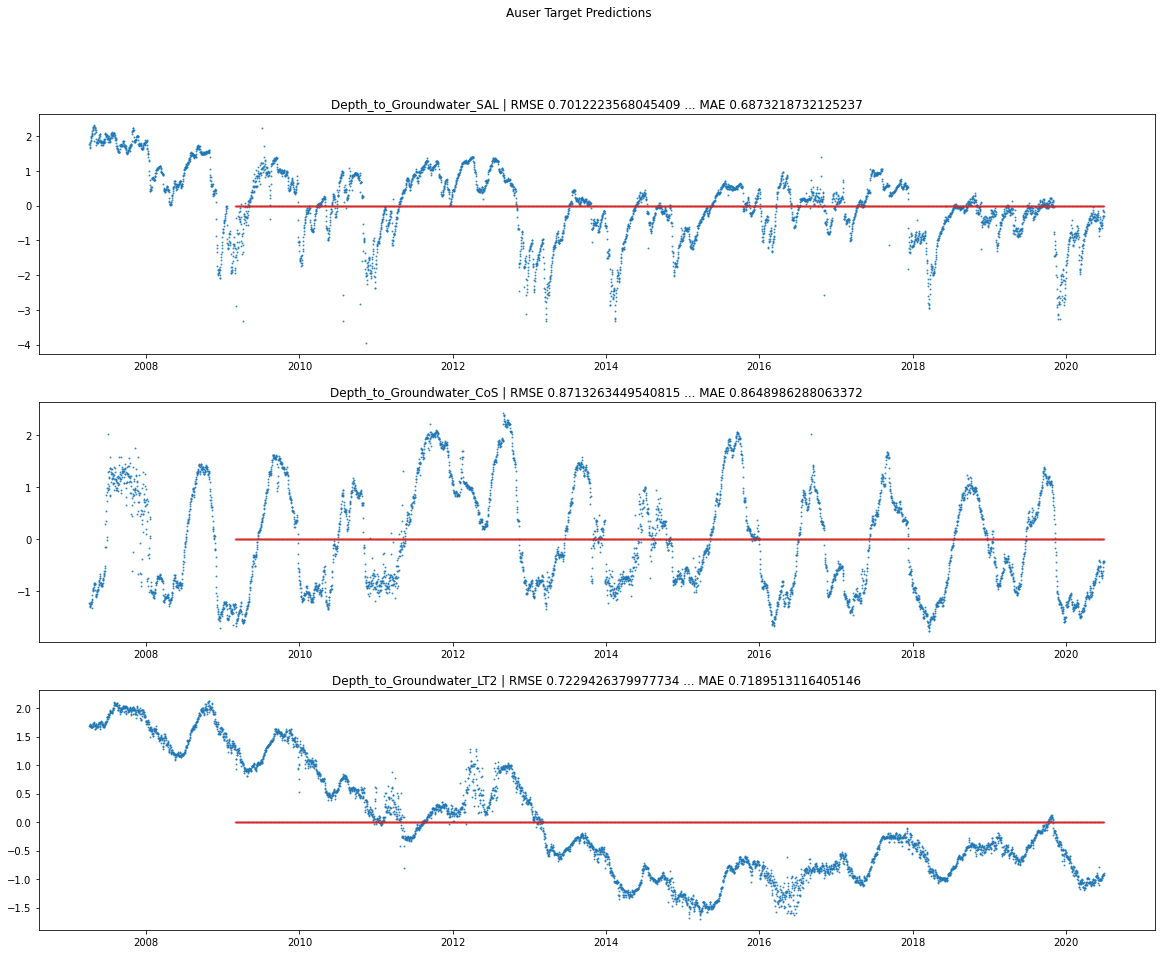

In [297]:
plot_target_predictions('Auser', auserY, [
    'Depth_to_Groundwater_SAL',
    'Depth_to_Groundwater_CoS',
    'Depth_to_Groundwater_LT2'
])

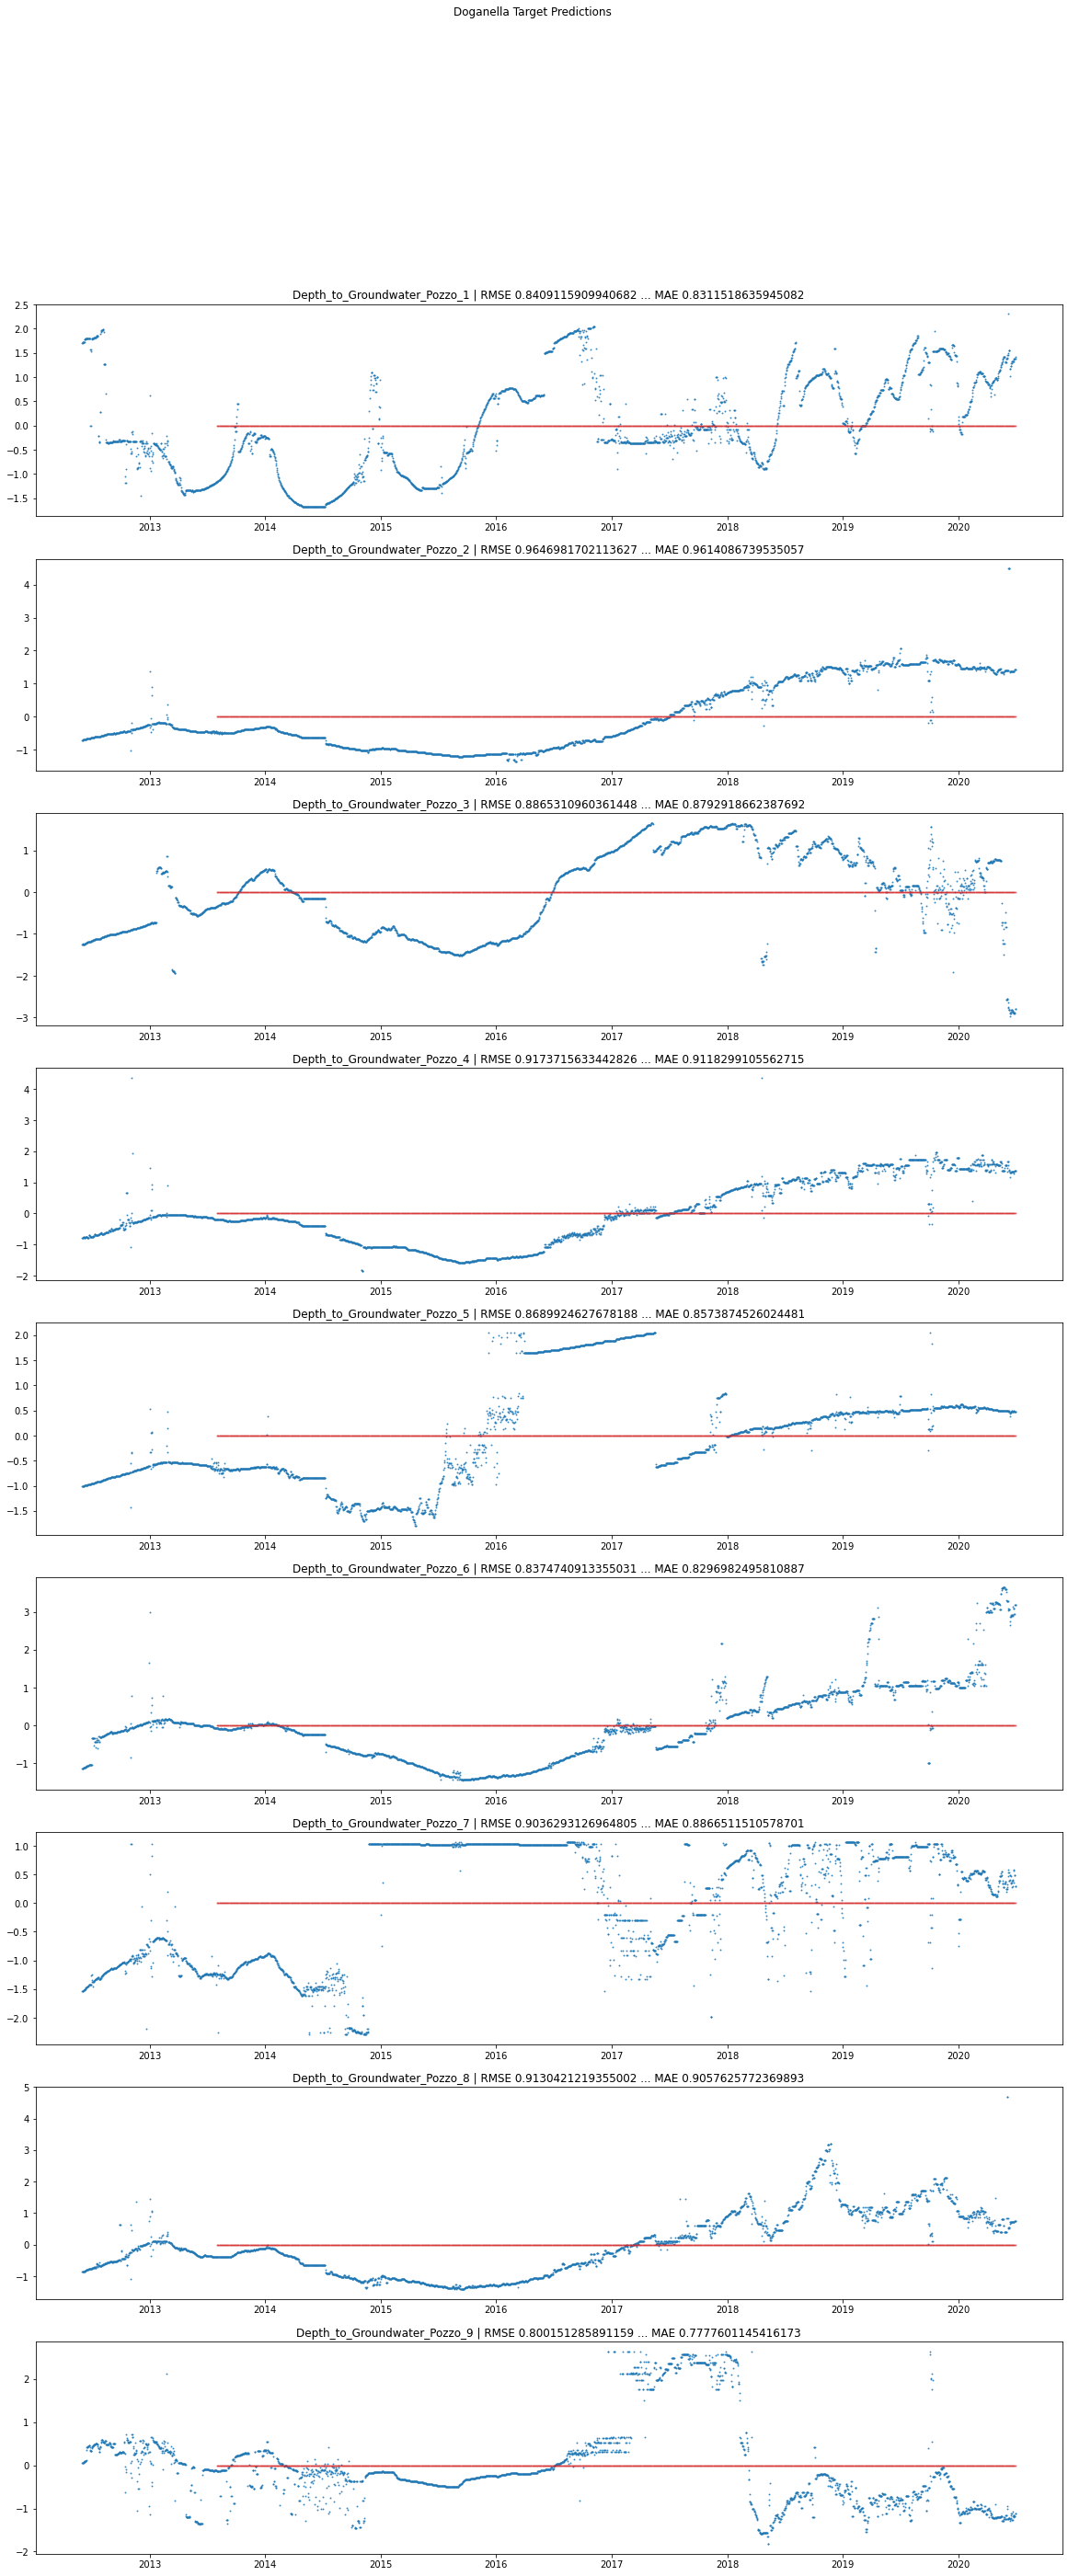

In [298]:
plot_target_predictions('Doganella', doganellaY, [f"Depth_to_Groundwater_Pozzo_{i+1}" for i in range(9)])

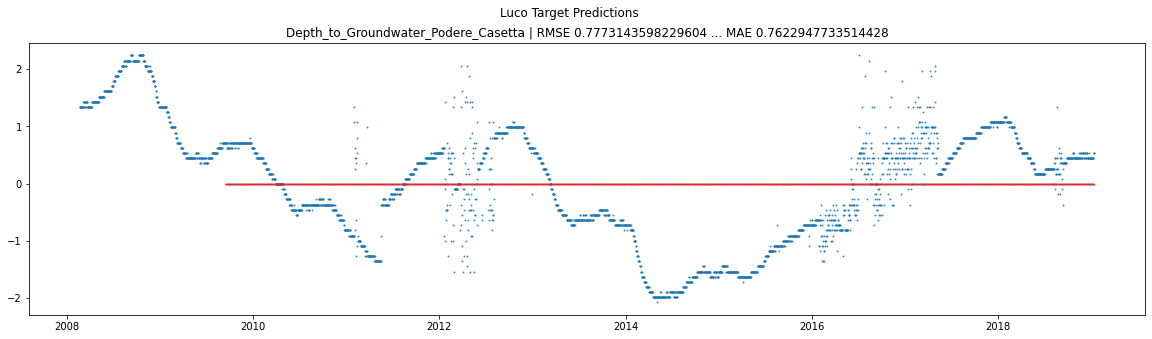

In [299]:
plot_target_predictions('Luco', lucoY, ['Depth_to_Groundwater_Podere_Casetta'])

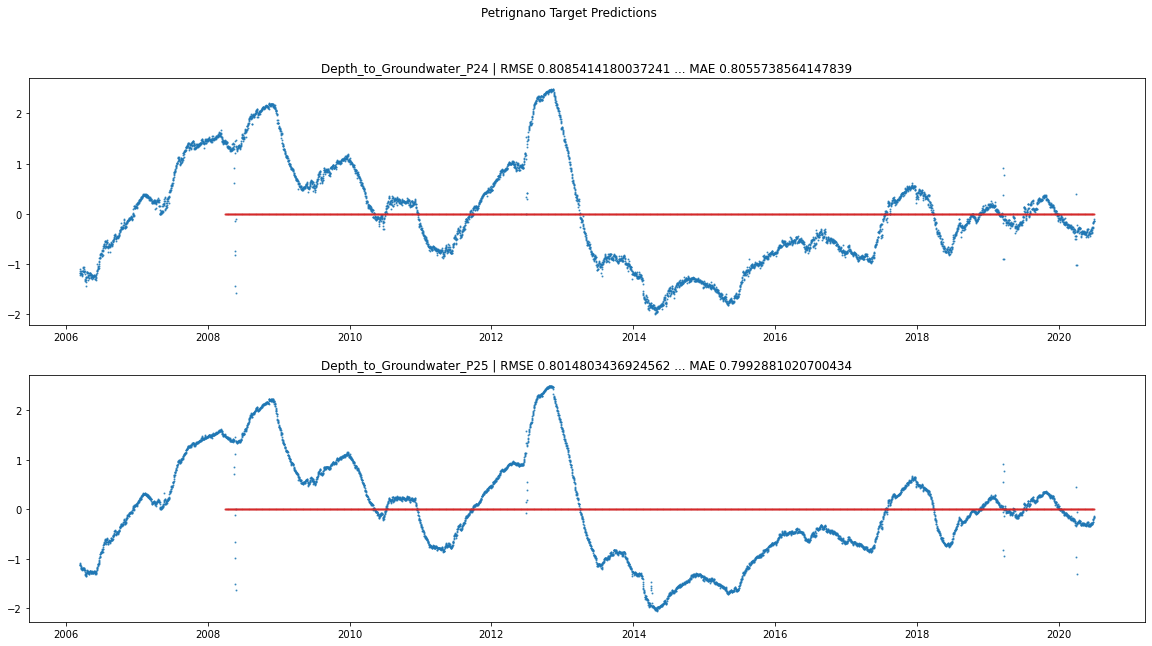

In [300]:
plot_target_predictions('Petrignano', petrignanoY, [
    'Depth_to_Groundwater_P24',
    'Depth_to_Groundwater_P25'
])

In [301]:
def get_cum_errs():
    means = [mean_scores[x].mean() for x in mean_scores]
    overall = pd.concat(means, axis=1).T
    return overall.mean()['rmse'], overall.mean()['mae']

In [ ]:
get_cum_errors()

# LET IT HERE BE KNOWN

When using the method of "always predict 0," our scores are such:

RMSE! 3.87797...  
MAE! 3.87773...

\*_for 7 day forecasts_  
\*\*_z-scored_